# [Analysis] Does Money Vote For Money?

*A billion here, a billion there; pretty soon you're talking about real money.*

During one of the discussions about the architecture and distribution of Reputation on the platform, @abh12345 said:

> [However, I would be keen on a Vested Steem Power analysis of voting - does money vote for money?](— https://steemit.com/utopian-io/@abh12345/steemit-steem-reputation-voting-analysis#@abh12345/re-lextenebris-re-abh12345-steemit-steem-reputation-voting-analysis-20180306t185234133z)

— https://steemit.com/utopian-io/@abh12345/steemit-steem-reputation-voting-analysis#@abh12345/re-lextenebris-re-abh12345-steemit-steem-reputation-voting-analysis-20180306t185234133z

... Which _is_ a really good question, as far as it goes, and I'm thinking its one that deserves a little poking at.

## Terms and Conditions

We have to start looking into this by defining more of what we're talking about. Is it just the general issue of do accounts with extremely high SP tended to restrict their votes to other accounts of extremely high SP? [I've already done the analysis for something like that,](https://steemit.com/steem/@lextenebris/steem-visualizing-vote-histories-on-the-blockchain) and the answer was, surprisingly, most of the votes occurring from the top 200 were going out of the network, and not into it.

But that says nothing about Reputation, which is an entirely orthogonal measure of account value. Accounts with high Reputation must have, for a considerable amount of time and at considerable effort, been outvoted by accounts with even higher Reputation.

I don't really understand what Reputation even looks like on the platform, so that's the place to start.

## Building Your Rep

In [87]:
# Setting up the imports for our basic query tools

from pprint import pprint

from steemdata import SteemData
import datetime
from datetime import datetime as dt

import math

import pandas as pd

import bokeh
import bokeh.plotting as bplt

In [88]:
# Init connection to database

db = SteemData()

In [89]:
# Just a list of all accounts with Rep over 30

query = {'reputation': {'$gte': 30}}

proj = {'name': 1,
        'reputation': 1,
        '_id': 0}

In [90]:
%%time

result = list(db.Accounts.find(query,
                               projection=proj,
                               sort=[],
                               limit=10))

Wall time: 103 ms


In [91]:
len(result)


10

That seems a legitimate kind of number. Let's look inside.

In [92]:
result[:5]

[{'name': 'a-acehsteem', 'reputation': 1567944952},
 {'name': 'a-aka-assassin', 'reputation': 1174954542},
 {'name': 'a-ayman', 'reputation': 114463809},
 {'name': 'a-b', 'reputation': 1998284910},
 {'name': 'a-dars', 'reputation': 17769912}]

Reputation is stored as a big, big number. Which may not be what we're looking for. Let's dig around and see if someone else is calculated how to derive the displayed Reputation number rather than the raw value.

[*How reputation scores are calculated - the details explained with simple math*](https://steemit.com/steemit/@digitalnotvir/how-reputation-scores-are-calculated-the-details-explained-with-simple-math)

Lucky for us it's simple, I suppose. Effectively you throw it on a log 10 curve, fiddle around so that the bottom end is squashed a bit and moved up to 25, and generally mischief managed.

Let's write a function to do that, because that's the sensible thing.

In [93]:
# Complete rewrite of the func because, well, you'll read down below.
#   See https://github.com/steemit/condenser/blob/ff705f7a413c64e513ecb7f1f6f66fee793a28c7/src/app/utils/ParsersAndFormatters.js

def steemBullshitLog10(Str):
    
    # Not in the original code, just better.
    if Str == '0':
        return 0
    
    leadingDigits = int(Str[:4])
    pad = len(Str) - 1
    
    # This is not a perfect replication; the JS library has a constant for log[10]
    
    strLog = math.log(leadingDigits) / math.log(10)
    
    return pad + (strLog - int(strLog))


def steemBullshitRep2Rep(RawI):
    RepS = str(RawI)
    
    IsRepNeg = RawI < 0
    
    if IsRepNeg:
        RepS = RepS[1:]
        
    RepI = steemBullshitLog10(RepS)
        
    RepI = max(RepI - 9, 0)
    
    if IsRepNeg:
        RepI *= -1
    
    RepI = (RepI * 9) + 25
    
    return RepI

In [94]:
# And now, let's write it the way it _should_ be written
#   given stated intent in the comments

def rep2Rep(RawI):
    if RawI:
        if RawI > 0:
            return  int(max((math.log( RawI, 10) - 9), 0) * 9) + 25
        else:
            return -int(max((math.log(-RawI, 10) - 9), 0) * 9) + 25
    else:
        # Because we arbitrarily center at 25
        return 25

In [95]:
rep2Rep(result[0]['reputation'])

26

This appears to work well enough for us. It does mean that we can't really query accounts for which ones have a minimum Reputation, not without doing some reverse engineering to find out what number would actually map to 30.

Maybe that would be worth doing.

[![Imgur](https://i.imgur.com/AfVsNrq.png?1)](https://goo.gl/JfM6vr)

Sometimes you go with what will get you the fastest answer, and when I need to do some sort of weird salt for a missing variable problem – I go to Wolfram Alpha.

(I know, I know – there are plenty of tools that I could've used straight in Python but they would've all taken more time to set up than simply going to webpage. (I know, I know – there are plenty of tools that I could've used straight in Python but they would've all taken more time to set up than simply going to webpage. Also, this function as given to Wolfram Alpha isn't strictly correct. There is a weird bit regarding the absolute value of the Reputation as stored when it is a negative number that I didn't put in – but which has retroactively been worked into `rep2Rep`. See all the advantages you get when you read these things when they're done and not while I'm writing them?))

Still, this tells us the amount of in-database Reputation that will equate to a minimum level for figuring out who is at least Reputation 30.

Let's plug that back in.

In [96]:
# Init connection to database

db = SteemData()

In [97]:
minRep = int(3.593813663804627302188167229038422636504 * 10**9)

In [98]:
minRep

3593813663

In [99]:
# Just a list of all accounts

query = {}

proj = {'name': 1,
        'reputation': 1,
        '_id': 0}

In [100]:
%%time

result = list(db.Accounts.find(query,
                               projection=proj,
                               sort=[]))

Wall time: 12.8 s


In [101]:
len(result)


788516

In [102]:
repCalc = [rep2Rep(int(e['reputation'])) for e in result]

In [103]:
len(repCalc)

788516

In [104]:
Data = pd.DataFrame({'name': [e['name'] for e in result],
                     'rep': [int(e['reputation']) for e in result],
                     'calcRep': [e for e in repCalc]
                    })

In [105]:
Data.sort_values('rep', ascending=False).head(3)

,calcRep,name,rep
513965,78,steemsports,913296035791209
293626,77,knozaki2015,746658070499557
410136,77,papa-pepper,682990070870322


In [106]:
Data.sort_values('rep', ascending=False).tail(3)

,calcRep,name,rep
340682,-15,matrixdweller,-29377009310460
580751,-16,wang,-37765258368568
59937,-17,berniesanders,-53479962528315


Getting that list took a lot more gyration than expected – because the values for Reputation as stored in the database are so large, they change type at some point and stop being 64-bit integers and start being strings.

@furion , if you're listening, they probably ought to be stored as *all* strings or an even bigger int if necessary. I would settle for strings, but one or the other should definitely happen. This mixed type solution is messy.

Anyway, we have a list of all the accounts on the system sorted by reputation, and how we can actually do some stuff with it.

In [107]:
cData = Data[Data['calcRep'] >= 40].sort_values('calcRep', ascending=False)

In [108]:
nData = cData.set_index('name')

In [109]:
nData.head()

,calcRep,rep
name,,
steemsports,78,913296035791209
gavvet,77,660761030588799
knozaki2015,77,746658070499557
papa-pepper,77,682990070870322
ozchartart,76,467589219907553


In [110]:
nData.tail()

,calcRep,rep
name,,
chadwickthecrab,40,58978979429
yudiananda,40,50125948491
mahmut,40,47287237996
mahmoodhassan,40,56958995698
yohamartinez,40,48050862479


In [111]:
len(nData)

55739

That is a lot lower number than I expected to see. In fact, I'm starting to wonder if poking around in this part of the world doesn't invalidate a lot of the things we've been told about the amount of live accounts on the platform. It's under 55,000 accounts with a reputation of "you've at least done something to create content", covering the entire life of the platform. 

In fact, I'm starting to wonder if poking around in this part of the world doesn't invalidate a lot of the things we've been told about the amount of live accounts on the platform.

That is not a great thing.

But before we go there, we need to talk about something you've already seen the evidence of up above…

## Who th'Hell Wrote This Tripe?

Look, I know it's been a long time since I had to maintain enterprise-class code. In the intervening years I may have become more cynical, more bitter, and even better at doing code analysis than I was in the heady years of my youth.

Which I despised, for the record. Going through someone else's code is like going through their sewer pipe. It's not even as dignified as going through their garbage. I enjoy going through the garbage.

Someone needs to find the people that wrote the connector and the JavaScript code originally for the steem blockchain, cut off their fingers, feed them their own fingers, and then possibly remove their ears and tongue so no one else has to listen to their insanity – because the actual code is actually bad.

I invite you to go and look at the article I linked earlier. You'll notice that it lightly outlines the Reputation calculation and then cites a piece of code and shows a piece of code. There is some reference to "details left out."

I'm here to tell you that what was left out up there was grade-A stupid.

Someone decided that the best way to implement a log base 10 algorithm was not to actually use floats or decent integer approximations, but instead to convert or use a string, snip off the first five characters of that string and convert it to an int, take the natural logarithm of that int and divide it by the natural logarithm of 10 (the only smart part of this algorithm), then crush those things back together, counting on the `parseInt` function in JavaScript to do the right thing and if they are slight offset in log calculation to effectively return the decimal portion of the base 10 logarithm of the overall request, and then pass it back.

But the stupid doesn't stop there, because the actual Reputation calculation maintains some of the calculation in an integer state and some in a string state, mashes things together willy-nilly, and hopes to Hell that `parseInt` can save the day again when they go to return the ultimate value.

This isn't just wrong. It's beyond wrong. Whoever wrote this code doesn't need to be allowed near keyboard for the safety of the entire application.

I can almost, kind of, if I tilt my head to the side 90° and then squint really hard, see what they were trying to do. There is a really clumsy attempt to keep from passing around large integers, which some bright soul decided that at least part of the Reputation fields in the blockchain itself would be stored as strings. Rather than simply read the value and immediately convert it to something useful like a 64-bit integer and doing the calculations sensibly in that domain, they decided to write their own base 10 logarithm code which is effectively just "tell me how long this string is -1", pass around a whole pile of strings, build and deconstruct strings, parse strings multiple times, and hit the stack on top of all of that.

Out of curiosity, pure curiosity, I decided to do a quick set of time comparisons of my proper version of the Reputation code, a pretty straightforward version of their Reputation code, and the dumbest possible implementation I could imagine which was just literally taking the length of an integer turned into a string and returning that as the base 10 logarithm.

Here's what that looks like.

In [112]:
%timeit -n 10 [rep2Rep(i) for i in range(1, 100000)][:5]

75 ms ± 681 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
%timeit -n 10 [steemBullshitRep2Rep(i) for i in range(1, 100000)][:5]

209 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
%timeit -n 10 [len(str(i)) - 1 + 25 for i in range(1, 100000)][:5]

34.6 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


I was impressed; it turns out that they only ran *a third* the speed of properly designed code. Though I could double the speed of my own if I replaced it with a purely naïve implementation. I'm not sure we would actually lose much accuracy in the presentation as a result, and since nothing actually hinges on the short form Reputation presentation, maybe these really ridiculous blocks of code could be replaced with even stupider but at least coherent blocks of code.

If you're curious where this stuff lives, be my guest and go gaze upon the horror with thine own eyes.

https://github.com/steemit/steem-js/blob/master/src/formatter.js

https://github.com/steemit/condenser/blob/ff705f7a413c64e513ecb7f1f6f66fee793a28c7/src/app/utils/ParsersAndFormatters.js

Now that's out of the way, let's check out what the distribution of Reputation looks like.

## Eye on the Prize(s)

At a certain point you just have to roll up your sleeves, flex your fingers, and get ready to get your hands dirty. I have a sneaking suspicion of what this is going to look like, right up front, but we'll take a look at how things actually shake out.

In [115]:
nData.head()

,calcRep,rep
name,,
steemsports,78,913296035791209
gavvet,77,660761030588799
knozaki2015,77,746658070499557
papa-pepper,77,682990070870322
ozchartart,76,467589219907553


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001220C3478D0>,
      dtype=object)

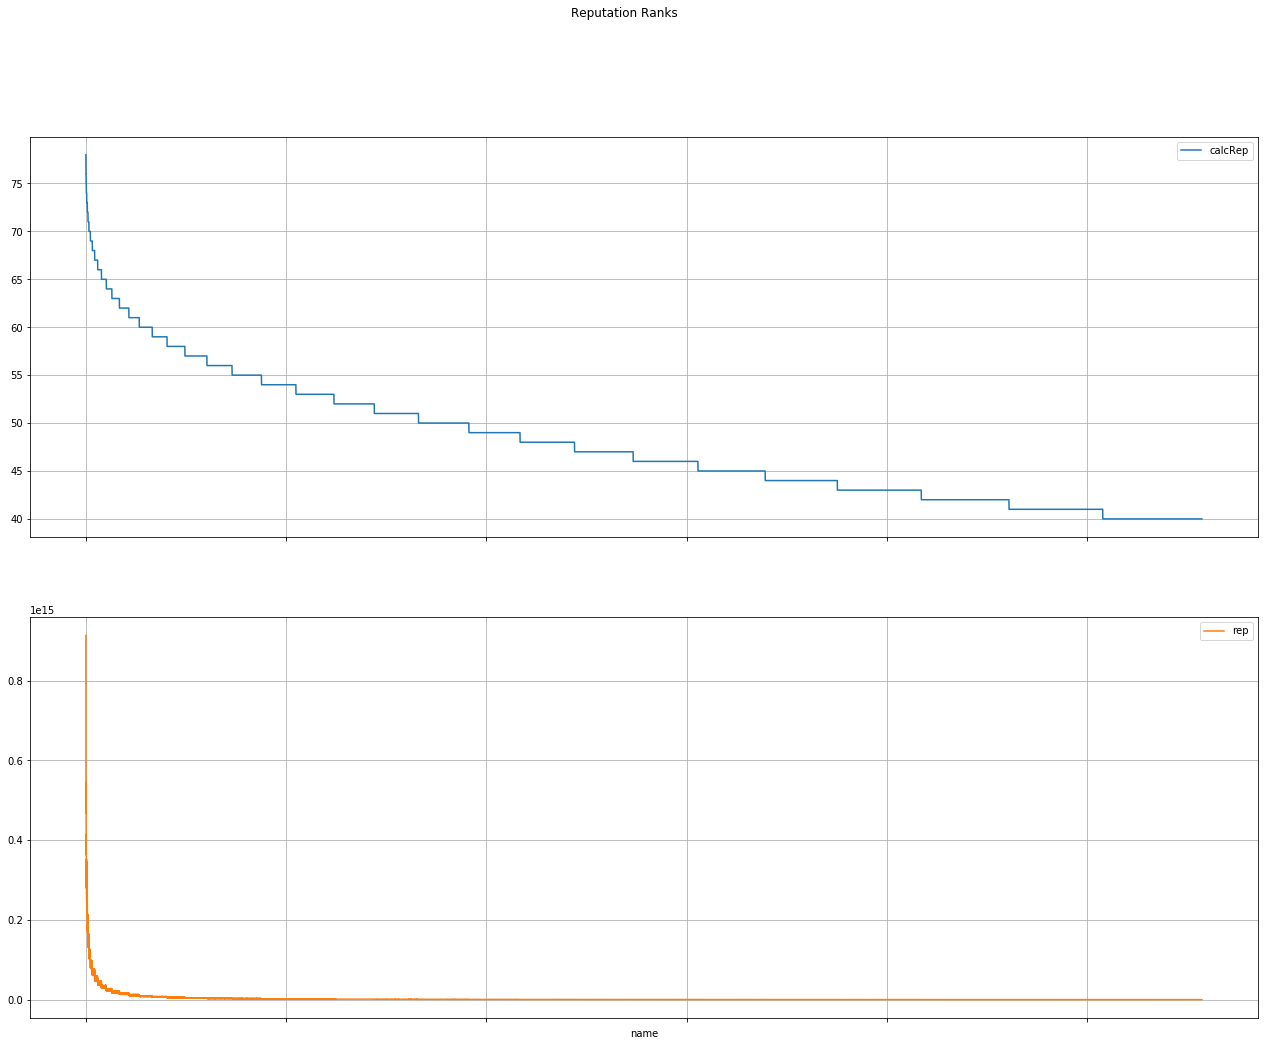

In [116]:
nData.plot(subplots=True, 
           figsize=(22, 18), 
           title='Reputation Ranks', 
           grid=True, 
          )

Does this look familiar to you?

If you've been reading any of the analysis that I've been doing over the last few weeks, it should. It looks like every other distribution curve on Steemit. Every single one. The difference between the top and bottom is that the top is taking the integer Reputation of all of the accounts with greater than 40 Rep, and the lower curve is those exact same accounts except with their raw reputation plotted.

Can you tell the immediate difference between the two?

If you've been following the functions I've been writing, you know – the calculated Reputation has an implicit logarithmic curve causing the vast slope of the actual underlying reputation to be somewhat masked. I've used logarithmic slopes before in showing SP distribution on the blockchain, and the results were exactly like this. It just lifted up the knee of the curve.

Is Reputation 40 high enough to count as "money," or should we take the limit even higher? Of course, as we raise our cutoff point, the population of people that we're talking about becomes very quickly much smaller. Let's redo this with Reputation 50+ and see where that puts us.

In [117]:
cData = Data[Data['calcRep'] >= 50].sort_values('calcRep', ascending=False)

In [118]:
nData = cData.set_index('name')

In [119]:
len(nData)

19129

In [120]:
nData.head()

,calcRep,rep
name,,
steemsports,78,913296035791209
papa-pepper,77,682990070870322
knozaki2015,77,746658070499557
gavvet,77,660761030588799
krnel,76,528772137201395


In [121]:
nData.tail()

,calcRep,rep
name,,
neesje,50,738360211524
ned-scott-videos,50,629802131081
tktk1023,50,732930735510
neclatenekeci,50,653698846700
wefund,50,680810981197


That takes us down to only 20,000 of the users on the platform and probably puts us in the right place to start wondering if all of the votes for this group stay within the group or fall outside of it?

Of course, we need to figure out what the scope of the votes we're interested in actually are. All votes on the platform would be far too much data to crunch and not very interesting. The last week might be acceptable, so let's target that first.

Step one is querying the database for all of the votes which were done by any of the people in this list within the last week.

In [122]:
intL = nData.index.tolist()

In [123]:
# Init connection to database

db = SteemData()

In [124]:
# Let's put our account on interest here in a list. One day
#   we might want to generalize to more than one.

intL = nData.index.tolist()

In [125]:
# We want only the vote transactions which have happened
#   in the last week AND involve only our accounts of interest. 

query = {
    'type' : 'vote',
    'timestamp' : {'$gte': dt.now() - datetime.timedelta(days=7)},
    '$or': [{'voter': {'$in': intL}}
           ]}

proj = {'voter': 1, 'author': 1, 'weight': 1, 'permlink': 1,
        '_id': 0}

In [126]:
%%time

result = db.Operations.find(query,
                            projection=proj)

votes = list(result)

Wall time: 1min 12s


In [127]:
votes[:5]

[{'author': 'appics',
  'permlink': 're-claudiaz-re-appics-announcing-appics-or-the-next-generation-social-app-or-first-smart-media-token-20171018t233054132z',
  'voter': 'sinner264',
  'weight': 1000},
 {'author': 'simone88',
  'permlink': 'colored-drawing-mayor-mccheese',
  'voter': 'biglipsmama',
  'weight': 300},
 {'author': 'novi',
  'permlink': 'wanita-tangguh-b2e0e2732f87c',
  'voter': 'good-karma',
  'weight': 6},
 {'author': 'edwardbernays',
  'permlink': 'basic-needs',
  'voter': 'youareyourowngod',
  'weight': 10},
 {'author': 'hninyu',
  'permlink': 'grilled-shrimp-a3c0635fbd3cb',
  'voter': 'cryptohustler',
  'weight': 50}]

In [128]:
len(votes)

1913625

Almost 2 million votes in the last week from the accounts in this pile.

That is a lot of voting.

Worse, though – it's just too many edges to deal with. Though maybe once we get this data into some sort of table that we can work with, structuring the output with some summaries and counts certainly may cut down on things – especially if there are a lot of commonalities.

What the Hell, let's give it a try.

In [129]:
vData = pd.DataFrame(votes)

In [130]:
vData.head()

,author,permlink,voter,weight
0,appics,re-claudiaz-re-appics-announcing-appics-or-the...,sinner264,1000
1,simone88,colored-drawing-mayor-mccheese,biglipsmama,300
2,novi,wanita-tangguh-b2e0e2732f87c,good-karma,6
3,edwardbernays,basic-needs,youareyourowngod,10
4,hninyu,grilled-shrimp-a3c0635fbd3cb,cryptohustler,50


In [131]:
veData = vData[vData['author'].isin(intL)]

In [132]:
len(veData)

1147353

In [133]:
len(veData) / len(vData)

0.5995704487556339

I suppose that we have an answer, really. Roughly 60% of the votes in the last week cast by accounts with Reputations greater than 50 went to other accounts with Reputations greater than 50.

But maybe it's not as bad as it looks, right? I mean, maybe all of the votes going inside the group are tiny votes, and they tend to vote with heavier weight outside of the group. That should be relatively easy to find out. All we need to do is sum up the weights on all the votes inside and in total, and a quick divisor will let us know what the ratio is.

In [134]:
vSum = vData['weight'].sum()

vSum

7303280912

In [135]:
veSum = veData['weight'].sum()

veSum

5232713161

In [136]:
veSum / vSum

0.7164880036864177

Oh.

71% by weight went to authors inside the group as opposed to merely 60% by count.

At this point it's getting hard to avoid finding that money does, in fact, vote for money.

But soft, what light through yonder window breaks?

What percentage of these votes are actually self-votes? Those would count as votes which were cast for someone within the same group, right? What percentage of the total are simply not getting out of the group because they are going to the voter themselves?

We can easily work this out.

In [137]:
vsData = vData[vData['author'] == vData['voter']]

In [138]:
len(vsData)

90695

In [139]:
vsSum = vsData['weight'].sum()

In [140]:
vsSum

835090614

In [141]:
len(vsData) / len(vData), vsSum / vSum

(0.047394343196812336, 0.11434458349094377)

Not *entirely* expected.

Only 4.7% of the total number of votes cast by accounts with a Reputation of greater than 50 were self-votes, which is relatively reassuring, I suppose. However, 11.4% of the total weight in votes cast by accounts with Reputation 50 or more went to self-voting.

I want to be clear at this point, I have no problem with people self-voting. I am a firm believer in "code is law," and the steem blockchain goes out of its way to reinforce at every turn that voting your own goods up with your own SP is one of the most efficient and effective ways of increasing your holdings.

You don't have to like it, but you do have to accept it.

This paints a very strange picture, in that 60% of votes in general go inside of the high reputation group, while 71% of the total vote weight stayed in the group. Only 4.7% of those votes were self votes, but they made up 11.4% of the total weight of votes cast.

Apparently, high Reputation accounts keep the SP in the family, with a tendency to vote other high Reputation accounts more aggressively, but of that 71% of vote power, roughly 11% were just voting for themselves.

That's really, really interesting. Like most of my findings, I don't know what it actually means – but we found it.

Out of curiosity, a truly perverse and probably self-destructive curiosity, what say we turn the breakpoint all the way up to Reputation 70 and see how the numbers fall out.

In [142]:
cData = Data[Data['calcRep'] >= 70].sort_values('calcRep', ascending=False)

In [143]:
nData = cData.set_index('name')

In [144]:
len(nData)

224

Only 224 accounts on the entire blockchain have a Reputation of over 70. I'm not sure if that's reassuring or terrifying. It is what it is.

In [145]:
nData.head()

,calcRep,rep
name,,
steemsports,78,913296035791209
gavvet,77,660761030588799
papa-pepper,77,682990070870322
knozaki2015,77,746658070499557
ozchartart,76,467589219907553


In [146]:
nData.tail()

,calcRep,rep
name,,
richman,70,114253548771732
reddust,70,100083302723374
rea,70,116140932922857
razvanelulmarin,70,108790190309091
fishingvideos,70,100154736138756


In [147]:
intL = nData.index.tolist()

In [148]:
# Init connection to database

db = SteemData()

In [149]:
# Let's put our account on interest here in a list. One day
#   we might want to generalize to more than one.

intL = nData.index.tolist()

In [150]:
# We want only the vote transactions which have happened
#   in the last week AND involve only our accounts of interest. 

query = {
    'type' : 'vote',
    'timestamp' : {'$gte': dt.now() - datetime.timedelta(days=7)},
    '$or': [{'voter': {'$in': intL}}
           ]}

proj = {'voter': 1, 'author': 1, 'weight': 1, 'permlink': 1,
        '_id': 0}

In [151]:
%%time

result = db.Operations.find(query,
                            projection=proj)

votes = list(result)

Wall time: 16.5 s


In [152]:
votes[:5]

[{'author': 'walidelhaddad',
  'permlink': 'binance-offers-usd250-000-bounty-for-arrest-of-hackers',
  'voter': 'cheetah',
  'weight': 8},
 {'author': 'carlitojoshua',
  'permlink': 'march-fire-prevention-month',
  'voter': 'juvyjabian',
  'weight': 1000},
 {'author': 'smilebot',
  'permlink': 'remember-to-smile-a2db16b93296a',
  'voter': 'cheetah',
  'weight': -8},
 {'author': 'wefund',
  'permlink': 'wefund-ada-1-3',
  'voter': 'krexchange',
  'weight': 10000},
 {'author': 'gabbybear',
  'permlink': 'international-women-s-day',
  'voter': 'juvyjabian',
  'weight': 1000}]

In [153]:
len(votes)

91305

91,000 total votes cast by accounts with Reputation 70 or greater. Compared to the number of votes that we been juggling along the way, this is very, very small. We are getting down into the realm of the graphable.

In [164]:
vData = pd.DataFrame(votes)

In [165]:
vData.head()

,author,permlink,voter,weight
0,walidelhaddad,binance-offers-usd250-000-bounty-for-arrest-of...,cheetah,8
1,carlitojoshua,march-fire-prevention-month,juvyjabian,1000
2,smilebot,remember-to-smile-a2db16b93296a,cheetah,-8
3,wefund,wefund-ada-1-3,krexchange,10000
4,gabbybear,international-women-s-day,juvyjabian,1000


In [166]:
veData = vData[vData['author'].isin(intL)]

In [167]:
len(veData)

12615

In [168]:
len(veData) / len(vData)

0.13816329883357975

In [169]:
vSum = vData['weight'].sum()

vSum

161766147

In [170]:
veSum = veData['weight'].sum()

veSum

54197247

In [171]:
veSum / vSum

0.3350345421777277

In [172]:
vsData = vData[vData['author'] == vData['voter']]

In [173]:
len(vsData)

2538

In [174]:
vsSum = vsData['weight'].sum()

In [175]:
vsSum

22746035

In [176]:
len(vsData) / len(vData), vsSum / vSum

(0.02779694430754066, 0.14061060006578507)

So there we have it.

Of accounts with Reputation 70+ who have voted in the last week:

- Nearly 14% by count of those votes went to other accounts with Reputation 70+.

- 33% by weight of those votes stayed with accounts with Reputation 70+.

- Only 2.7% of those votes by count were self-votes.

- But nearly 15% by weight of those votes were self-votes.

Looking at the list of accounts in the Reputation 70+ category, this is not surprising news.

## *Epilogue*

So what have we learned here, today?

Money does, in fact, vote for money. Quite a lot of the time. Not only does it vote for money, it votes for itself quite often. The class of accounts with high Reputations focus on, whether intentionally or emergently, other accounts with high Reputations.

The percentages by count decrease as the Reputation breakpoint increases, but not faster than the number of accounts involved decreases. And when talking about vote weight, which is purely about percentages, there seems to be an active centralization as you go up.

Of accounts with Reputation 40+, it's not surprising that the vast bulk of their vote weight goes within the group. That includes moderately successful and established small bloggers with communities who have managed to tough it out and are still around.

Once we start talking about 70+, however – it's an entirely different world. Keep in mind, 14% of their total votes for the week went to one of the other 224 accounts of comparable level.

We haven't even dealt with the question of how many of these accounts are automated as opposed to manual, which is an entirely orthogonal question that probably deserves some kind of attention. Is it possible to gain an extremely high Reputation via automated means?

There are definitely some bots in this group, particularly up voting bots. That means that they have not only been uploaded by new users, but have a long history of being up voted by higher Reputation accounts as well. It's not something that we can blame on uncouth newbies.

This is interesting stuff. Hopefully someone else finds it as interesting as I do.

### Tools

* [Python 3.6](https://www.python.org/)
* [Jupyter Lab](https://github.com/jupyterlab/jupyterlab)
* [SteemData](https://steemdata.com/) created by @furion
* [MongoDB](https://www.mongodb.com/)
* [Pandas](https://pandas.pydata.org/)

**And the letter "YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY?!"**